# Insider Trading 💸
#### Data Cleaning

In [18]:
import json

with open('trades.ndjson') as f:
    trades = [json.loads(row) for row in f.read().splitlines()]

#print(trades[0]["URLs"]["Page"])  

In [19]:
flattenedRows = [
    {
        j: y
        for (i, x) in row.items()
        for (j, y) in (
            {f"{i}.{j}": y for (j, y) in x.items()} if type(x) is dict else {i: x}
        ).items()
    }
    for row in trades
]
# flattenedRows[:1]


In [20]:
import pandas as pd

df = pd.DataFrame.from_records(
    [list(row.values()) for row in flattenedRows],
    columns=list(flattenedRows[0].keys())
)

# df.head()

In [21]:
import datetime
from pandas.tseries.offsets import MonthEnd


df_filtered = df.drop(columns=['URLs.Page', 'URLs.Row', 'Issuer.URL', 'Politician.URL', 'Additional Information', 'Original Filing', 'Filed'])
# df_filtered = df_filtered[df_filtered['Asset Type'] == "Stock"]
df_filtered = df_filtered.loc[df_filtered["Asset Type"] == "Stock"]

df_filtered["Traded"] = pd.to_datetime(df_filtered["Traded"], unit='ms').dt.date
df_filtered["DATE"] = (pd.to_datetime(df_filtered["Published"], unit='ms') + MonthEnd(0))

In [22]:
ranges_list = []

for row in df_filtered["Amount"]:
    row = row.split("–")
          
    for num in row:

        if isinstance(num, str) and "K" in num:
            num = num.replace("K", "")
            num = int(num) * 1000
            ranges_list.append(num)
        
        if isinstance(num, str) and "M" in num :
            num = num.replace("M", "")
            num = int(num) * 1000000
            ranges_list.append(num)
        
        if isinstance(num, str) and "$" in num:
            ranges_list.append(num)

print([value for value in ranges_list if isinstance(value, str) and "$" in value])

['$1,000,000', '$582', '$652', '$902', '$877', '$802', '$971', '$819', '$797', '$497', '$675', '$1,000', '$500', '$500', '$500', '$500', '$500', '$4,451', '$4,451', '$20,955', '$11,836', '$1,797', '$20,541', '$43,165', '$27,641', '$66,048', '$18,662', '$11,572', '$1,891', '$3,268', '$12,114', '$32,178', '$7,769', '$20,770', '$7,553', '$9,329', '$10,576', '$34,078', '$5,149', '$25,597', '$3,314', '$16,330', '$17,531', '$21,253', '$21,775', '$14,889', '$15,788', '$127,575', '$44,819', '$2,161', '$25,586', '$21,394', '$13,056', '$23,896', '$4,810', '$48,770', '$7,368', '$12,986', '$17,929', '$22,974', '$8,593', '$21,414', '$4,240', '$15,128', '$14,846', '$7,401', '$462,100', '$400,000', '$1,000,000', '$500,000', '$1,000,000', '$4,183', '$7,198', '$4,293', '$9,219', '$7,318', '$6,099', '$7,477', '$13,168', '$14,116', '$1,653', '$7,595', '$13,515', '$7,760', '$7,239', '$20,888', '$8,340', '$9,006', '$7,419', '$4,581', '$24,777', '$5,117', '$16,200', '$3,542', '$1,155', '$11,812', '$15,194',

In [23]:
from statistics import mean 

ranges = []
r = []

for item in enumerate(ranges_list):
    if isinstance(item[1], str) and "$" in item[1]:
        r.append(int(item[1].replace("$","").replace(",", "")))
        ranges.append(r[0])
        r = []
        continue
    if item[0]%2 == 0:
        r.append(item[1])
    else:
        r.append(item[1])

        ranges.append(r)
        r = []

df_filtered["Quantity"] = ranges

range_averages = []

for pair in ranges:
    if isinstance(pair, int):
        range_averages.append(pair)
    else:
        range_averages.append(mean(pair))

df_filtered["Quantity.Averages"] = range_averages

transaction_total = []
quantity_directional = []

for row in df_filtered.index:
    if df_filtered.loc[row, "Transaction Type"]=="buy":
        transaction_total.append(df_filtered.loc[row, "Quantity.Averages"] * df_filtered.loc[row, "Price"] )
        quantity_directional.append(df_filtered.loc[row,"Quantity.Averages"])
    else:
        quantity_directional.append(df_filtered.loc[row,"Quantity.Averages"] * -1)
        transaction_total.append(df_filtered.loc[row, "Price"] * df_filtered.loc[row, "Quantity.Averages"] * -1)

df_filtered["Transaction.Total"] = transaction_total
df_filtered["Quantity.Averages"] = quantity_directional

In [24]:
df_filtered = df_filtered.dropna()
df_filtered.reset_index(drop=True)

tickers = [ticker.replace(":US", "").replace("/B", "").replace("/A", "") for ticker in df_filtered["Issuer.Ticker"] if isinstance(ticker, str)]

df_filtered["TICKER"] = tickers

In [25]:
ticker_permno_conversion = pd.read_csv('ticker_permno_conversion.csv')

ticker_permno_conversion = ticker_permno_conversion.dropna()
ticker_permno_conversion['DATE'] = [date.replace("-", "") for date in ticker_permno_conversion['DATE']]
ticker_permno_conversion['DATE'] = pd.to_datetime(ticker_permno_conversion['DATE'], format='%Y%m%d')
valid_tickers = ticker_permno_conversion['TICKER'].tolist()

df_filtered = df_filtered[df_filtered['TICKER'].isin(valid_tickers)].reset_index(drop=True)

def make_permno(df):
    groups = ticker_permno_conversion.groupby('TICKER', sort=False)

    def get_permno(row):
        (ticker, date) = row['TICKER'], row['DATE']

        group = groups.get_group(ticker).sort_values(by=['DATE'])

        index = (date >= group['DATE'])[::-1].idxmax()
        
        return group.loc[index,'PERMNO']

    return df[['TICKER', 'DATE']].apply(get_permno, axis=1)

df_filtered['PERMNO'] = make_permno(df_filtered)

In [26]:
df_filtered["Price"] = df_filtered["Price"].replace(',','', regex=True)
df_filtered["Price"].astype("float")


0        102.11
1        232.16
2        232.16
3        112.31
4        133.27
          ...  
33217     23.92
33218    156.11
33219     38.82
33220     76.38
33221    180.55
Name: Price, Length: 33222, dtype: float64

In [27]:
df_filtered



,Amount,Issuer.Name,Issuer.Ticker,Politician.Chamber,Politician.Name,Politician.Party,Politician.State,Transaction Type,Traded,Published,...,Asset Type,Price,Shares,Filed After,DATE,Quantity,Quantity.Averages,Transaction.Total,TICKER,PERMNO
0,1K–15K,Amazon.com Inc,AMZN:US,House,Morgan McGarvey,Democrat,Kentucky,buy,2023-02-07,1679637600000,...,Stock,102.11,10 - 147,44 days,2023-03-31 06:00:00,"[1000, 15000]",8000,816880.0,AMZN,84788
1,1K–15K,NVIDIA Corporation,NVDA:US,House,Morgan McGarvey,Democrat,Kentucky,sell,2023-02-28,1679637600000,...,Stock,232.16,5 - 65,23 days,2023-03-31 06:00:00,"[1000, 15000]",-8000,-1857280.0,NVDA,86580
2,1K–15K,NVIDIA Corporation,NVDA:US,House,Morgan McGarvey,Democrat,Kentucky,sell,2023-02-28,1679637600000,...,Stock,232.16,5 - 65,23 days,2023-03-31 06:00:00,"[1000, 15000]",-8000,-1857280.0,NVDA,86580
3,100K–250K,Conocophillips,COP:US,House,Michael McCaul,Republican,Texas,buy,2023-02-13,1679551200000,...,Stock,112.31,"891 - 2,226",35 days,2023-03-31 06:00:00,"[100000, 250000]",175000,19654250.0,COP,13928
4,50K–100K,Arista Networks Inc,ANET:US,House,Michael McCaul,Republican,Texas,buy,2023-02-10,1679551200000,...,Stock,133.27,376 - 751,38 days,2023-03-31 06:00:00,"[50000, 100000]",75000,9995250.0,ANET,14714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,1K–15K,BP PLC,BP:US,House,Virginia Foxx,Republican,North Carolina,buy,2020-03-30,1585807200000,...,Stock,23.92,42 - 628,2 days,2020-04-30 06:00:00,"[1000, 15000]",8000,191360.0,BP,29890
33218,1K–15K,Microsoft Corp,MSFT:US,Senate,Pat Roberts,Republican,Kansas,buy,2020-03-26,1585461600000,...,Stock,156.11,7 - 96,2 days,2020-03-31 06:00:00,"[1000, 15000]",8000,1248880.0,MSFT,10107
33219,1K–15K,Exxon Mobil Corp,XOM:US,Senate,Pat Roberts,Republican,Kansas,buy,2020-03-26,1585461600000,...,Stock,38.82,26 - 386,2 days,2020-03-31 06:00:00,"[1000, 15000]",8000,310560.0,XOM,11850
33220,1K–15K,Chevron Corp,CVX:US,Senate,Pat Roberts,Republican,Kansas,buy,2020-03-26,1585461600000,...,Stock,76.38,14 - 196,2 days,2020-03-31 06:00:00,"[1000, 15000]",8000,611040.0,CVX,14541


## Project Actually Starts Here
#### Starting with Speakers of the House: Nancy Pelosi (2019 - Jan 3, 2023) and Kevin McCarthy (Jan 7th 2023 - present)

In [49]:
from datetime import datetime
import os
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.ticker import FormatStrFormatter

In [29]:
# Define class here
class InsiderDataProcessor():
    
    # Path to where we store the data
    #data_folder_path = Path('C:/Users/katewang/Downloads/InsiderTrading/') 
    
    # Minimum share price to open a new position
    min_share_price = 3.0
    
    # Constructor, loads/cleans/merges data as needed
    def __init__(self, filtered_df):
        #reading and formatting monthly_returns
        self.price_df = pd.read_csv('monthly_returns.csv')
        self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'], format ="%Y%m%d")
        self.price_df.loc[:,'prc'] = np.absolute(self.price_df.loc[:,'prc'])
        self.price_df.loc[:,'ret_next'] = safe_lead_lag(self.price_df.loc[:,'ret'],self.price_df.loc[:,'permno'],1)
        
        #our signal_df is our filtered_df
        self.signal_df = filtered_df.copy()
        self.signal_df.rename(columns={'PERMNO': 'permno', 'Quantity.Averages': 'quantity'}, inplace=True)

        
    def unique_dates(self):
        price_dates =  pd.Series(np.sort(self.price_df.loc[:,'date'].unique()))
        min_signal_date = self.signal_df.loc[:,'DATE'].min()
        max_signal_date = self.signal_df.loc[:, 'DATE'].max() 

        return price_dates[(min_signal_date < price_dates) & (price_dates < max_signal_date)].array
    
    def price_df_for_date(self,date):
        price_date_df = self.price_df.loc[ self.price_df.loc[:,'date'] == date, :]
        return price_date_df.rename(columns={'permno':'security_id'}) 
    
    def signal_df_for_date(self,date):
        date_price_df = self.price_df.loc[ self.price_df.loc[:,'date'] == date,:]
        date_price_df = date_price_df.loc[ np.isfinite(self.price_df.loc[:,'ret_next']),:]
        date_price_df = date_price_df.drop(columns=['ret_next'])
        
        latest_signal_df = self.signal_df.loc[self.signal_df.loc[:,'DATE'].dt.date == date.date(),:]
        latest_signal_df['Price'] = pd.to_numeric(latest_signal_df['Price'], errors='coerce')

        # group by permno so there is one row only, probably .sum()
        # print(latest_signal_df["Price"].iloc[0].dtype)
        
        # latest_signal_df = latest_signal_df.groupby(['permno'])['quantity'].agg({'quantity':'sum', 'Price':'mean'})
        latest_signal_df = latest_signal_df.groupby('permno', as_index=False).agg({'quantity':'sum', 'Price':'mean'})
 
        merged_df = date_price_df.merge(latest_signal_df,on='permno',how='inner')
        merged_df = merged_df.rename(columns={'permno':'security_id'})  # use permno as our security_id

        
        merged_df = self.liquidity_filter(merged_df)
        
        return merged_df

    def liquidity_filter(self,df):
        return df.loc[ df.loc[:,'prc'] >= self.min_share_price,:]
        
###################################################################
# Helper methods, do not modify
###################################################################
def safe_lead_lag(data_series,group_series,lead_lag): 
    df = pd.DataFrame({ 'data': data_series, 'group': group_series })
    return df.groupby(['group'])['data'].shift(-lead_lag)


In [30]:
# data_processor = InsiderDataProcessor(df_filtered)

# unique_dates = data_processor.unique_dates()
# unique_dates[0]

# # data_processor.signal_df

# # data_processor.price_df_for_date(unique_dates[2])

# data_processor.signal_df_for_date(unique_dates[0])

# # test_signal_df


In [31]:
class PortfolioDB():
    
    # Maintenance margin requirement for each asset (as a fraction of absolute market value)
    maint_margin_frac = 0.5
    
    # Do not modify these
    cash_security_id = 'cash'     # Security identifier for cash
    ret_tallied_dates = set()     # Set of dates we've already tallied
    
    
    # Initialization function (aka constructor) that runs whenever you create a new PortfolioDB() elsewhere, for example: portfolio_db = PortfolioDB()
    def __init__(self) :
        self.positions_df = self.empty_positions_df()
        self.trades_df = self.empty_trades_df()
        self.account_history_df = self.empty_account_history_df()

    def empty_positions_df(self):
        return pd.DataFrame({'security_id': pd.Series([], dtype='object'), #security identifier such as ticker or permno or optionid whatever unique identifier for the position
                             'quantity': pd.Series([], dtype='float'), # number of units in portfolio, can be positive or negative. Never 0 (zero positions removed from this DataFrame unless its cash)
                             'average_cost': pd.Series([], dtype='float'), # average cost of units in portfolio
                             'current_price': pd.Series([], dtype='float') # current price of security
                            })
    
    def empty_trades_df(self):
        return pd.DataFrame({'security_id': pd.Series([], dtype='object'), # ticker or permno or optionid whatever unique identifier for the position
                             'quantity': pd.Series([], dtype='float'), # number of units traded. positive = buy, negative = sell
                             'open_datetime': pd.Series([], dtype='datetime64[ns]'), # datetime on which the trade was opened
                             'open_average_price': pd.Series([], dtype='float'), # average open price of the units in the trade                                              
                             'close_datetime': pd.Series([], dtype='datetime64[ns]'), # datetime on which the trade was closed
                             'close_average_price': pd.Series([], dtype='float') # average close price of the units in the traade
                            })
    
    def empty_account_history_df(self):
        return pd.DataFrame({'datetime': pd.Series([], dtype='datetime64[ns]'), # datetime on which the account data was recorded
                             'nav': pd.Series([], dtype='float'), # account net asset value
                             'cash_position': pd.Series([], dtype='float'), # account cash position
                             'margin_requirement': pd.Series([], dtype='float') # account margin requirement
                            })
        
    def add_cash(self,cash_to_add):        
        if( not self.positions_df['security_id'].str.contains(self.cash_security_id).any() ):
            # Append is being deprecated, so we need to switch to concat
            self.positions_df = pd.concat([ self.positions_df, pd.DataFrame({'security_id':[self.cash_security_id],'quantity':[0], 'average_cost':[1], 'current_price':[1]})])
             # self.positions_df = self.positions_df.append(pd.DataFrame({'security_id':[self.cash_security_id],'quantity':[0], 'average_cost':[1], 'current_price':[1]}))
                

        self.positions_df.loc[self.positions_df['security_id']==self.cash_security_id,'quantity'] += cash_to_add
        
    def open_trades(self,open_trades_df):     
        validate_df_columns(open_trades_df,['security_id','open_datetime','quantity','open_average_price'])
        
        if open_trades_df['security_id'].dtype != object:            
            open_trades_df['security_id'] = open_trades_df['security_id'].astype(object)
                
        open_trades_df = groupby_agg_wavg(df=open_trades_df, group_by=['security_id','open_datetime'],
                                          default_method='first',
                                          wavg_columns=['open_average_price'],
                                          wavg_weight='quantity')

        self.trades_df = pd.concat([ self.trades_df, open_trades_df ])
        
        self.add_cash( -(open_trades_df['open_average_price']*open_trades_df['quantity']).sum() )
            
        trades_position_df = open_trades_df.loc[:,['security_id', 'quantity', 'open_average_price']] 
        trades_position_df = trades_position_df.rename(columns={'open_average_price':'average_cost'}) 
            
        self.append_positions(trades_position_df)
                        
        self.remove_zero_positions() 
        
    def close_trades(self,close_trades_df):
        validate_df_columns(close_trades_df,['security_id','open_datetime','close_datetime','close_average_price'])

        close_trades_df = close_trades_df.groupby(['security_id','open_datetime']).agg('first').reset_index() 
        close_trades_df = close_trades_df.astype({'security_id':'object', 'open_datetime':'datetime64[ns]'})
        
        self.trades_df = self.trades_df.merge(close_trades_df, on=['security_id','open_datetime'], suffixes=('','_cldf'), how='left')

        just_closed = self.trades_df.loc[:,'close_datetime_cldf'].notnull()
    
        self.trades_df.loc[just_closed,'close_datetime'] = pd.to_datetime(self.trades_df.loc[just_closed,'close_datetime_cldf'])
        self.trades_df.loc[just_closed,'close_average_price'] = self.trades_df.loc[just_closed,'close_average_price_cldf']
        
        self.trades_df = self.trades_df.loc[:,~self.trades_df.columns.str.endswith('_cldf')]

        self.add_cash( (self.trades_df.loc[just_closed,'close_average_price']*self.trades_df.loc[just_closed,'quantity']).sum() )
        
        trades_position_df = self.trades_df.loc[just_closed,['security_id', 'quantity', 'open_average_price']]
        trades_position_df = trades_position_df.rename(columns={'open_average_price':'average_cost'}) 
        trades_position_df['quantity'] = trades_position_df['quantity']*(-1) # negate quantity because we are closing
        
        self.append_positions(trades_position_df)     
        
        self.remove_zero_positions() 
    
    def update_prices(self,price_df):
        validate_df_columns(price_df,['security_id','prc','ret'])
        validate_all_values_same(price_df['date'])
                
        if price_df.loc[:,'security_id'].dtype != object:            
            price_df.loc[:,'security_id'] = price_df.loc[:,'security_id'].astype(object)
        
        self.positions_df = self.positions_df.merge(price_df.loc[:,['security_id','prc','ret']],on='security_id',how='left')
        self.positions_df.loc[:,'ret'] = self.positions_df.loc[:,'ret'].fillna(0)
                
        self.positions_df.loc[:,'lagged_price'] = self.positions_df.loc[:,'current_price']
        
        self.positions_df.loc[:,'current_price'] = np.where(self.positions_df.loc[:,'prc'].notnull(),
                                                            self.positions_df.loc[:,'prc'],
                                                            self.positions_df.loc[:,'current_price'])
        
        null_current_price = self.positions_df.loc[:,'current_price'].isna()
        self.positions_df.loc[null_current_price,'current_price'] = self.positions_df.loc[null_current_price,'average_cost']
        
        date = price_df.loc[:,'date'].iloc[0]
        
        if( date not in self.ret_tallied_dates ):
            self.positions_df.loc[:,'ret_based_price'] = self.positions_df.loc[:,'lagged_price']*(self.positions_df.loc[:,'ret']+1)
            
            self.positions_df.loc[:,'quantity_multiple'] = self.positions_df.loc[:,'ret_based_price'] / self.positions_df.loc[:,'current_price']
            self.positions_df.loc[:,'quantity'] = self.positions_df.loc[:,'quantity']*self.positions_df.loc[:,'quantity_multiple']
            
            self.positions_df = self.positions_df.drop(columns=['ret_based_price'])
            
            still_open = self.trades_df.loc[:,'close_datetime'].isna() 
            
            if( not still_open.empty ):  
                self.trades_df = self.trades_df.merge(self.positions_df.loc[:,['security_id','quantity_multiple']],
                                                      on=['security_id'],
                                                      suffixes=('','_posdf'),
                                                      how='left')
                self.trades_df.loc[still_open,'quantity'] = self.trades_df.loc[still_open,'quantity']*self.trades_df.loc[still_open,'quantity_multiple']          
            
                self.trades_df = self.trades_df.loc[:,~self.trades_df.columns.str.endswith('_posdf')]

                self.trades_df = self.trades_df.drop(columns=['quantity_multiple'])                
            
            self.ret_tallied_dates.add(date)
        
        self.positions_df = self.positions_df.drop(columns=['prc','lagged_price','ret'])
    
    def remove_zero_positions(self): 
        prices = np.where( self.positions_df.loc[:,'current_price'].notnull(),
                          self.positions_df.loc[:,'current_price'],
                          self.positions_df.loc[:,'average_cost'] )
        self.positions_df = self.positions_df[ (np.abs(self.positions_df.loc[:,'quantity']*prices) > 1.0E-5) |
                                               (self.positions_df.loc[:,'security_id'] == 'cash') ]
        
    def record_account_data(self,price_df,datetime):
        self.update_prices(price_df)
        self.account_history_df = pd.concat([ self.account_history_df, 
                                             pd.DataFrame({'datetime':[datetime],'nav':[self.current_nav()], 'cash_position':[self.current_cash()], 'margin_requirement':[self.current_margin()]}) ] )
        
    def current_nav(self):
        return (self.positions_df.loc[:,'current_price']*self.positions_df.loc[:,'quantity']).sum()
    
    def current_cash(self):
        return self.positions_df.loc[self.positions_df.loc[:,'security_id']==self.cash_security_id,'quantity'].sum()
    
    def current_margin(self):
        return self.maint_margin_frac*(np.absolute(self.positions_df['current_price']*self.positions_df['quantity']).sum() - abs(self.current_cash()))

    def append_positions(self,new_position_df):
        self.positions_df = pd.concat([ self.positions_df, new_position_df ])
        
        self.positions_df = groupby_agg_wavg(df=self.positions_df, group_by='security_id', default_method='last', wavg_columns=['average_cost'], wavg_weight='quantity')
        
        self.positions_df.loc[ self.positions_df.loc[:,'average_cost'] < 0.1, 'average_cost' ] = np.NaN
        
        

def groupby_agg_wavg(df, group_by, default_method='sum', specified_methods={}, wavg_columns=[], wavg_weight=''):    
    starting_col_names = df.columns
    starting_col_types = df.dtypes

    df2 = df.copy() # don't want to modify original passed in
    
    # create dictionary that will map column names to functions used for aggregation
    method_dict = dict.fromkeys(df2.columns,default_method)  # start with using default_method for all columns
    method_dict.update(specified_methods) # update with any specified methods. dict.update modifies the dictionary and does NOT return one
    
    # create columns for weight*var 
    temp_columns = ['wtimes_' + s for s in wavg_columns] # name temp columns wtimes_<original_name>
    df2[temp_columns] = df2[wavg_columns].multiply(df2[wavg_weight], axis='index') # multiply by weights
    method_dict.update( dict.fromkeys(temp_columns,'sum') ) # want to sum these cols when we aggregate
    method_dict[wavg_weight] = 'sum' # need to sum the wavg weight
    
    # run actual groupby, resetting index
    df2 = df2.groupby(group_by).agg(method_dict).reset_index(drop=True)
    
    # use weight*var sum columns to go back to actual weighted average
    df2[wavg_columns] = df2[temp_columns].divide(df2[wavg_weight], axis='index')
    
    # go back to original column names in correct order
    df2 = df2[starting_col_names]
    df2 = df2.astype(starting_col_types)
    
    return df2 

def validate_df_columns(df,required_columns):
    for col in required_columns:
        if col not in df.columns:
            raise ValueError('DataFrame missing required column named \'' + col + '\'' )

def validate_all_values_same(series):
    np_array = series.to_numpy()
    if not (np_array[0] == np_array).all():
        raise ValueError('Series has multiple unique values but is required to have only one')
        
def validate_no_missing_values(series):
    if( series.isna().sum() > 0 ):
        raise ValueError('Series has missing value but is required to have none')

In [32]:
class InsiderTradingRule():
    # strategy: always long top 10% by B/M and short bottom 10% by B/M, equal-weighted or value-weighted
    # For each $1 NAV, we open $1 total of long positions AND $1 total of short positions
    # This would be the max leverage allowed given 50% margin requirements
    #
    # Assume 100% of portfolio liquidated each month and repurchased with new quantities
    
    # strategy-specifc columns for trades_df (variables we want to keep track of for subsequent analysis)
    # usually the variables that led the strategy to open trade in the first place
    # In this case, just book-to-market ratio 'bm'
    strategy_specific_trades_df_columns = {'bm': pd.Series([], dtype='float')} 

    # minumum number of stocks with available bm for us to actually trade
    min_stocks_available = 100
    
    # value weighted?
    value_weighted = False
    
    def __init__(self,portfolio_db):
        self.portfolio_db = portfolio_db
    
    # Regardless of the strategy you are implementing, this method must return
    # open_trades_df, close_trades_df
    #
    # open_trades_df is a DataFrame with all the required trades_df columns plus any custom ones for this strategy
    #     each row is a new trade the strategy wants to open
    #     method only populates the security_id (index) and quantity required columns, plus any custom columns. Rest remain NaN to be populated elsewhere
    # close_trades_df is a DataFrame that is a subset of the rows of portfolio_db.trades_df
    #     each row is an exist trade the strategy wants to close
    #     we don't need to populate any columns in this function
    def compute_trades(self,signal_df):                
        close_trades_df = self.portfolio_db.trades_df.loc[self.portfolio_db.trades_df.loc[:,'close_datetime'].isna(), :].copy()

        signal_df.rename(columns={'permno':'security_id'}, inplace=True)


        # buys_df = signal_df.loc[:,signal_df['Quantity.Averages'] > 0]
        buys_df = signal_df.loc[(signal_df.loc[:,'quantity'] > 0) & (signal_df.loc[:,"Price"].notnull()),:].copy()
        sells_df = signal_df.loc[(signal_df.loc[:,'quantity'] <= 0) & (signal_df.loc[:,"Price"].notnull()),:].copy()


        #weights
        overall_buys = (buys_df.loc[:, "Price"]*buys_df.loc[:, "quantity"])
        overall_buys = overall_buys.apply(pd.to_numeric, errors='coerce')

        buy_w = overall_buys/overall_buys.sum()

        overall_sells = sells_df.loc[:, "Price"]*sells_df.loc[:, "quantity"]
        overall_sells = overall_sells.apply(pd.to_numeric, errors='coerce')

        sell_w = overall_sells/overall_sells.sum()

        buys_dollar = self.portfolio_db.current_nav() * buy_w
        sells_dollar = self.portfolio_db.current_nav() * sell_w

        buys_df['quantity'] = buys_dollar / buys_df.loc[:,"Price"]
        sells_df['quantity'] = sells_dollar / sells_df.loc[:,"Price"]


        open_trades_df = self.empty_trades_df().append(buys_df.loc[:,['security_id', 'quantity']]).append(sells_df.loc[:,['security_id', 'quantity']])
        
        return open_trades_df, close_trades_df
    
    # Returns an empty trades_df
    # Used so we know the right columns to populate when creating a trades_df else
    def empty_trades_df(self):
        return pd.concat([self.portfolio_db.empty_trades_df(), pd.DataFrame(self.strategy_specific_trades_df_columns)], axis=1)
        

In [33]:
# portfolio_db = PortfolioDB()
# portfolio_db.add_cash(100)

# data_processor = InsiderDataProcessor(df_filtered)
# trading_rule = InsiderTradingRule(portfolio_db)

# %run backtest_executor.ipynb
# trading_rule.compute_trades(data_processor.signal_df)
# # test_open_trades_df, test_closed_trades_df = trading_rule.compute_trades(data_processor.signal_df)


In [50]:
class BacktestStatistican(): 
    
    # Where the market data file is located
    # Must have columns for 'mkt_index' (cumulative index of "market" returns) and
    # 'rf_index' (cumulative index of "risk-free" returns)
    market_data_path = 'mkt_rf_daily.csv'
    
    # Constructor stores references to the portfolio_db object and strategy_info dictionary
    #
    # strategy_info dictionary must have:
    #     'brief descriptor': description used for folder name 
    #     'plot descriptor': description used for plot header
    #     'universe': brief explanation of strategy's universe
    #     'signals': brief explanation of strategy's signals
    #     'trading rule': brief explanation of strategy's trading rule
    #     'holding period': strategy holding period (string)
    #     'periods per year': periods per year (number)
    #     'time lag': description of strategy's lag between signal time and its availability for trading
    #     'output folder name': folder to put all the output subfolders in
    def __init__(self, portfolio_db, strategy_info):
        self.portfolio_db = portfolio_db
        self.strategy_info = strategy_info
        # Get the folder this all goes in
        self.output_folder_path = self.make_backtest_path(strategy_info['output folder name'])
      
    # Outputs statistics and plots to files
    def output_stats(self):               
        
        # Output full csvs for account_history and trades
        self.portfolio_db.account_history_df.to_csv( self.output_folder_path / 'account_history.csv' )
        self.portfolio_db.trades_df.to_csv( self.output_folder_path / 'trades.csv' )
        
        # Compute and output main stats, which will go in this dictionary
        backtest_stats = dict()
        
        # Get the return series from the account history
        ret_series = self.portfolio_db.account_history_df.loc[:,'nav'].pct_change().dropna().reset_index(drop=True)
        
        # Number of periods per year for annualization
        N = self.strategy_info['periods per year']
        
        # means
        backtest_stats['arith mean'] = ret_series.mean()
        backtest_stats['arith mean (ann)'] = ret_series.mean()*N
        backtest_stats['geomean mean'] = stats.gmean(1+ret_series)-1
        backtest_stats['geomean mean (ann)'] = stats.gmean(1+ret_series)**N-1
        
        # risks
        backtest_stats['sigma'] = ret_series.std()
        backtest_stats['sigma (ann)'] = ret_series.std()*(N**0.5)
        drawdown = 1-self.portfolio_db.account_history_df.loc[:,'nav'] / self.portfolio_db.account_history_df.loc[:,'nav'].cummax()
        backtest_stats['avg drawdown'] = drawdown.mean()
        backtest_stats['max drawdown'] = drawdown.max()
        
        # alpha/beta
        mkt_rf_df = pd.read_csv(self.market_data_path)
        mkt_rf_df.loc[:,'date'] = pd.to_datetime(mkt_rf_df.loc[:,'date'],format='%Y%m%d')
        mkt_rf_df = mkt_rf_df.loc[mkt_rf_df.loc[:,'date'].isin(self.portfolio_db.account_history_df.loc[:,'datetime']),:]
        mkt_series = mkt_rf_df.loc[:,'mkt_index'].pct_change().dropna().reset_index(drop=True)
        rf_series = mkt_rf_df.loc[:,'rf_index'].pct_change().dropna().reset_index(drop=True)
        
        # Set up left- and right-hand sides for regressions
        lhs = ret_series
        rhs = sm.add_constant( mkt_series - rf_series )
        
        # Run the regression 
        model = sm.OLS(lhs,rhs) 
        results = model.fit()
        
        # extract alpha and beta
        backtest_stats['alpha'] = results.params['const']
        backtest_stats['alpha SE'] = results.bse['const']
        backtest_stats['alpha (ann)'] = results.params['const']*N
        backtest_stats['alpha SE (ann)'] = results.bse['const']*N
        backtest_stats['beta'] = results.params[0]
        backtest_stats['betaSE'] = results.bse[0]        
        
        # ratios        
        backtest_stats['Sharpe ratio'] = backtest_stats['arith mean'] / backtest_stats['sigma']
        backtest_stats['Sharpe ratio (ann)'] = backtest_stats['arith mean (ann)'] / backtest_stats['sigma (ann)']
        backtest_stats['information ratio'] = backtest_stats['alpha'] / backtest_stats['sigma']
        backtest_stats['information ratio (ann)'] = backtest_stats['alpha (ann)'] / backtest_stats['sigma (ann)']
        
        # Turn into a dataframe and output as csv
        pd.DataFrame.from_dict(data=backtest_stats, orient='index').to_csv(self.output_folder_path / 'backtest_stats.csv')
        
        self.nav_plot()
        
    # Make and output the cumulative NAV history plot    
    def nav_plot(self):

        plt.style.use('default')  # set plot style to 'default' 

        # Standard set-up for a matplotlib plot
        fig = plt.figure(figsize=(20,5)) # this will automatically show the most updated version of the plot after you run the cell, so no need to have a "fig" line later again
        ax = fig.add_subplot(1,1,1)
        plotdates = self.portfolio_db.account_history_df.loc[:,'datetime']
        ax.plot(plotdates, self.portfolio_db.account_history_df.loc[:,'nav'] / self.portfolio_db.account_history_df.loc[:,'nav'].iloc[0]) 
        
        # Customize the plot properties
        ax.set_xlabel('Date')
        ax.set_yscale('log')
        ax.yaxis.set_major_locator( ticker.LogLocator(base=2) )        
        ax.yaxis.set_minor_locator( ticker.LogLocator(base=2, subs=[1.25, 1.5, 1.75]))
        ax.yaxis.set_major_formatter( ticker.ScalarFormatter() )
        ax.yaxis.set_minor_formatter( ticker.NullFormatter() )
        ax.set_ylabel(self.strategy_info['plot descriptor'])
        ax.set_xlim(plotdates.min(), plotdates.max())
        # ax.xaxis.set_major_formatter( mdates.DateFormatter('%M-%Y'))  # format the tick labels using years            
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        plt.xticks(rotation=45)    
        plt.title("NAV of Congressional Copycat Portfolio")
        ax.yaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
        # plt.gca().set_ylim(0,3)
        # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
        # y=[1,1.8]
        # plt.yticks(np.arange(min(y), max(y), 0.2))

        # Save in our folder
        plt.savefig(self.output_folder_path / 'nav_plot.png', bbox_inches='tight', dpi=500)        
        
    # Create the path object for the folder used for the backtest output
    # The folder name will look like stratname_YYYYmmddHHMm
    def make_backtest_path(self, output_folder):
        output_path = Path(output_folder) 
        
        # This is the output name we want
        folder_name = '{0}_{1}'.format(self.strategy_info['brief descriptor'], datetime.now().strftime('%Y%m%d%H%M'))
        self.output_folder_path = Path(output_path / folder_name)  
    
        # It's possible the folder already exists, if it does add a ' (1)' or ' (2)' or however high we need to go
        # This follows the Windows convention for duplicate files
        num_attempts = 1
        while( self.output_folder_path.exists() ):
            folder_name_conflict = folder_name + ' ({0})'.format(num_attempts)
            self.output_folder_path = Path(output_path / folder_name_conflict)  
            num_attempts += 1
            
        self.output_folder_path.mkdir(parents=True)
        
        return self.output_folder_path
        

'2022-12-30: 10465424.369543796 | 1.1539086699485779e-05'

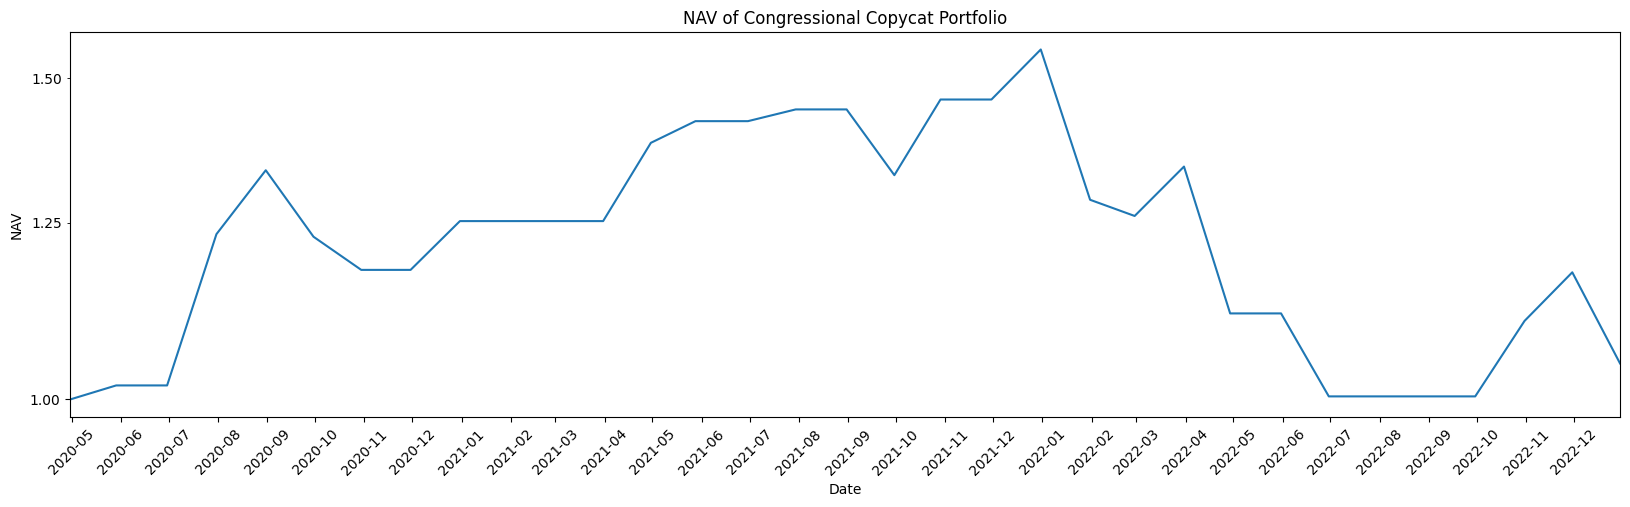

In [51]:
from IPython.display import clear_output

%run backtest_executor.ipynb 

data_processor = InsiderDataProcessor(df_filtered) 

portfolio_db = PortfolioDB()

trading_rule = InsiderTradingRule(portfolio_db)

trade_executor = BacktestExecutor(portfolio_db)

#MUST CHANGE 🤡🔫
strategy_info = {
    'brief descriptor': 'Insider Trading - Congress', 
    'plot descriptor': 'NAV',
    'universe': 'Public US equities',
    'signals': "Congress Officials' Stock Trades",
    'trading rule': 'Buy when officials buy, short when officials sell/short',
    'holding period': 'One month',
    'periods per year': 12,
    'time lag': 'End of the Published Date month (ex: PublishedDate = 1/20/2020, OurTradingDay = [last trading day of Jan])',
    'output folder name': 'Output'
}

statistican = BacktestStatistican(portfolio_db,strategy_info)

portfolio_db.add_cash(10000000)

udates = data_processor.unique_dates()

# Main loop for the backtest
for date in udates:
    # dataframes for the date
    signal_df = data_processor.signal_df_for_date(date)
    price_df = data_processor.price_df_for_date(date)

    print(signal_df.columns)

    # Update prices to reflect the new values after however much time has passed
    # Need to dot his first each date because the updated prices may affect our trading rule
    portfolio_db.update_prices(price_df)
    
    # Ask the trading rule what trades we should make
    open_trades_df, close_trades_df = trading_rule.compute_trades(signal_df=signal_df)

    # apply dates to trades
    open_trades_df.loc[:,'open_datetime'] = date
    close_trades_df.loc[:,'close_datetime'] = date

    # execute trades
    trade_executor.execute_opens(open_trades_df=open_trades_df, price_df=price_df)
    trade_executor.execute_closes(close_trades_df=close_trades_df, price_df=price_df)    
    
    # Record account data for today
    portfolio_db.record_account_data(price_df=price_df,datetime=date)
    
    # Do some fancy output tracking our NAV and margin requirement each day
    clear_output(wait=True)
    display( np.datetime_as_string(np.datetime64(date), unit='D') + ': ' + str(portfolio_db.current_nav()) + " | " + str(portfolio_db.current_margin()))
    
# Now that the loop is done, tell the statistican to output stats
statistican.output_stats()